# MLP GenCode 
Wen et al 2019 used DNN to distinguish GenCode mRNA/lncRNA.
Based on K-mer frequencies, K={1,2,3}, they reported 99% accuracy.
Their CNN used 2 Conv2D layers of 32 filters of width 3x3, max pool 2x2, 25% drop, dense 128.
Can we reproduce that with MLP layers instead of CNN?
Extract features as list of K-mer frequencies for K={1,2,3}.

In [73]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-07-10 17:18:25 UTC


In [74]:
PC_TRAINS=8000
NC_TRAINS=8000
PC_TESTS=2000
NC_TESTS=2000   # Wen et al 2019 used 8000 and 2000 of each class
PC_LENS=(200,4000)
NC_LENS=(200,4000)    # Wen et al 2019 used 250-3500 for lncRNA only
MAX_K = 3
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=64
EPOCHS=50
SPLITS=5
FOLDS=1   # make this 5 for serious testing

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint


In [76]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

On Google CoLab, mount cloud-local file, get our code from GitHub.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Data Load
Restrict mRNA to those transcripts with a recognized ORF.

In [77]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME

In [78]:
# Full GenCode ver 38 human is 106143 pc + 48752 nc and loads in 7 sec.
# Expect fewer transcripts if special filtering is used.
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
trivial=False
if trivial:
  print("Trivialize the data...")
  dummy='AAAA'*200
  for i in range(0,len(pcdf)):
    pcdf['sequence']=dummy
  dummy='GGGG'*200
  for i in range(0,len(ncdf)):
    ncdf['sequence']=dummy
show_time()

PC seqs loaded: 70825
NC seqs loaded: 48752
2021-07-10 17:18:30 UTC


## Data Prep

In [79]:
def dataframe_length_filter(df,low_high):
    (low,high)=low_high
    # The pandas query language is strange, 
    # but this is MUCH faster than loop & drop.
    return df[ (df['seqlen']>=low) & (df['seqlen']<=high) ]
def dataframe_shuffle(df):
    # The ignore_index option is new in Pandas 1.3. 
    # The default (False) replicates the old behavior: shuffle the index too.
    # The new option seems more logical th
    # After shuffling, df.iloc[0] has index == 0.
    # return df.sample(frac=1,ignore_index=True)
    return df.sample(frac=1)  # Use this till CoLab upgrades Pandas
def dataframe_extract_sequence(df):
    return df['sequence'].tolist()

pc_all = dataframe_extract_sequence(
    dataframe_shuffle(
    dataframe_length_filter(pcdf,PC_LENS)))
nc_all = dataframe_extract_sequence(
    dataframe_shuffle(
    dataframe_length_filter(ncdf,NC_LENS)))

show_time()
print("PC seqs pass filter:",len(pc_all))
print("NC seqs pass filter:",len(nc_all))
# Garbage collection to reduce RAM footprint
pcdf=None
ncdf=None

2021-07-10 17:18:30 UTC
PC seqs pass filter: 55381
NC seqs pass filter: 46919


In [80]:
# Any portion of a shuffled list is a random selection
pc_train=pc_all[:PC_TRAINS] 
nc_train=nc_all[:NC_TRAINS]
pc_test=pc_all[PC_TRAINS:PC_TESTS] 
nc_test=nc_all[NC_TRAINS:PC_TESTS]
# Garbage collection
pc_all=None
nc_all=None

In [81]:
def prepare_x_and_y(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    labels1=np.ones(len1,dtype=np.int8)
    labels0=np.zeros(len0,dtype=np.int8)
    all_labels = np.concatenate((labels1,labels0))
    seqs1 = np.asarray(seqs1)
    seqs0 = np.asarray(seqs0)
    all_seqs = np.concatenate((seqs1,seqs0),axis=0)
    #return all_seqs,all_labels  # test unshuffled
    tandem = (all_seqs,all_labels)
    X,y = shuffle(tandem) # sklearn.utils.shuffle
    return X,y
Xseq,y=prepare_x_and_y(pc_train,nc_train)
show_time()

2021-07-10 17:18:30 UTC


In [82]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    empty = tool.make_dict_upto_K(max_K)
    collection = []
    for seq in seqs:
        counts = empty
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
show_time()
print("X shape",np.shape(Xfrq))
print(type(Xfrq),"of",type(Xfrq[0]),"of",type(Xfrq[0][0]))
print("y shape",np.shape(y))

2021-07-10 17:18:41 UTC
X shape (16000, 84)
<class 'numpy.ndarray'> of <class 'numpy.ndarray'> of <class 'numpy.float64'>
y shape (16000,)


## Neural network

In [83]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    #dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                5440      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_________________________________________________________________
None


In [84]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/50
400/400 [==============================] - 2s 3ms/step - loss: 0.6624 - accuracy: 0.6270 - val_loss: 0.9787 - val_accuracy: 0.0000e+00
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6642 - accuracy: 0.6248 - val_loss: 0.9635 - val_accuracy: 0.0000e+00
Epoch 3/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6613 - accuracy: 0.6292 - val_loss: 0.9549 - val_accuracy: 0.0000e+00
Epoch 4/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6657 - accuracy: 0.6218 - val_loss: 1.1260 - val_accuracy: 0.0000e+00
Epoch 5/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6618 - accuracy: 0.6256 - val_loss: 1.0762 - val_accuracy: 0.0000e+00
Epoch 6/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6654 - accuracy: 0.6181 - val_loss: 0.9483 - val_accuracy: 0.0000e+00
Epoch 7/50
400/400 [=========

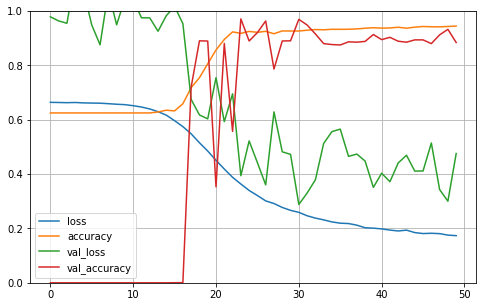

In [85]:
do_cross_validation(Xfrq,y)

In [86]:
# TO DO: run trained model on (pc_test,nc_test)
# and draw the AUC.
# Borrow code from other notebooks.